In [20]:
# Imports and Setup
import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import jax
from jax import jit
import jax.numpy as jnp
import jax.scipy.integrate as integrate

# Custom imports
# Get the current directory of the script
#current_dir = os.path.dirname(os.path.abspath(__file__))
current_dir = os.getcwd()
# Navigate to the target directory (`/home/houtlaw/iono-net/model`)
model_dir = os.path.abspath(os.path.join(current_dir, "../../model"))

# Add the model directory to sys.path if it's not already there
if model_dir not in sys.path:
    sys.path.append(model_dir)

print(f"Added {model_dir} to sys.path")
from Helper import *
from Image import *
from Psi import *
from Optimize import *
from model import ConfigurableModel

# Matplotlib settings
plt.rcParams.update({'font.size': 22})
rcParams["figure.figsize"] = (30, 8)
plt.rcParams["savefig.dpi"] = 300

# Parameters
SAMPLE_IDX = 2
DX = 0.25
ISLR_RADIUS = 5 # min distance between scatterers
ISLR_RADIUS_RATIO = 0.6 # ratio of radius for sidelobe integral
ISLR_MAIN_LOBE_WIDTH = 0.75 #fixed main lobe width
COMPARISON_SAMPLE_SIZE = 10

# File paths
DATA_DIR = "/home/houtlaw/iono-net/data/baselines/10k_lownoise"
X_RANGE_PATH = f"{DATA_DIR}/meta_X_20250206_104914.csv"
SETUP_PATH = f"{DATA_DIR}/setup_20250206_104914.json"
SCATTERER_PATH_RELNOISE = f"{DATA_DIR}/test_nuStruct_withSpeckle_20250206_104911.csv"
SIGNAL_PATH_RELNOISE = f"{DATA_DIR}/test_uscStruct_vals_20250206_104913.csv"
KPSI_PATH = f"{DATA_DIR}/kPsi_20250206_104914.csv"
PSI_COEFFS_PATH_RELNOISE = f"{DATA_DIR}/test_compl_ampls_20250206_104913.csv"
MODEL_WEIGHTS_PATH = "/home/houtlaw/iono-net/model/model_weights.pkl"

Added /home/houtlaw/iono-net/model to sys.path


In [21]:
def convert_to_complex(s):
    s = str(s)
    if s == "NaNNaNi":
        return 0
    return complex(s.replace('i', 'j'))

def split_complex_to_imaginary(complex_array):
    return np.concatenate([complex_array.real, complex_array.imag], axis=-1)

def load_data():
    # Load x_range
    x_range = pd.read_csv(X_RANGE_PATH).iloc[:, 0].values

    # Load setup parameters
    with open(SETUP_PATH) as f:
        setup = json.load(f)

    # Load true scatterers with noise
    true_scatterers = pd.read_csv(SCATTERER_PATH_RELNOISE).map(convert_to_complex).iloc[:, SAMPLE_IDX]
    true_scatterers = true_scatterers.map(np.abs).values

    # Load signal data
    signal_data = pd.read_csv(SIGNAL_PATH_RELNOISE).map(convert_to_complex).T.iloc[SAMPLE_IDX].values
    signal_vals = np.vstack((x_range, signal_data))

    # Load kpsi values
    kpsi_values = pd.read_csv(KPSI_PATH).values

    # Load psi coefficients
    psi_coeffs_df = pd.read_csv(PSI_COEFFS_PATH_RELNOISE).T
    psi_coeffs_df = psi_coeffs_df.map(lambda x: complex(x.replace('i', 'j')))
    psi_coeffs_vals = psi_coeffs_df.iloc[SAMPLE_IDX].values

    return x_range, setup, true_scatterers, signal_vals, kpsi_values, psi_coeffs_vals

In [22]:
x_range, setup, true_scatterers, signal_vals, kpsi_values, psi_coeffs_vals = load_data()

# === NEW PART: Trim leading/trailing zero-padding from signal ===
# If signal is complex, use magnitude for detecting zeros
signal_array = signal_vals[1, :]  # the 2nd row are the signal samples
nonzero_mask = np.abs(signal_array) > 1e-12
nonzero_indices = np.where(nonzero_mask)[0]

if len(nonzero_indices) == 0:
    # Edge case: everything is zero; no trimming possible
    print("All signal samples are zero. Using the original arrays.")
else:
    start_idx, end_idx = nonzero_indices[0], nonzero_indices[-1]
    
    # Trim x_range and signal
    trimmed_x = x_range[start_idx : end_idx + 1]
    trimmed_signal = signal_array[start_idx : end_idx + 1]
    
    # Reassign for use in the rest of the pipeline
    x_range_trunc = trimmed_x
    signal_vals_trunc = np.vstack((trimmed_x, trimmed_signal))
    print(f"Trimmed signal shape: {signal_vals_trunc.shape}, new x-range shape: {x_range_trunc.shape}")

# Retrieve parameters
F, ionoNHarm, xi, windowType, sumType = (
    setup["F"], 
    setup["ionoNharm"], 
    setup["xi"], 
    setup["windowType"], 
    setup["sumType"],
)

# Split psi coefficients into cosine and sine components
cos_coeffs = [j.real for j in psi_coeffs_vals]
sin_coeffs = [-j.imag for j in psi_coeffs_vals]

# Create Psi object
rec_fourier_psi = RecFourierPsi(cos_coeffs, sin_coeffs, kpsi_values, ionoNHarm)
rec_fourier_psi.cache_psi(x_range_trunc, F, DX, xi)

# Create image object
image_object = Image(x_range_trunc, window_func=rect_window, signal=signal_vals_trunc, psi_obj=rec_fourier_psi, F=F)
image_integral = image_object._evaluate_image()


Trimmed signal shape: (2, 1041), new x-range shape: (1041,)
Signal shape: (2, 1041)
without_psi_heights.shape: (201,)
psi_vals.shape: (201,)
without_psi_heights.shape: (202,)
psi_vals.shape: (202,)
without_psi_heights.shape: (203,)
psi_vals.shape: (203,)
without_psi_heights.shape: (204,)
psi_vals.shape: (204,)
without_psi_heights.shape: (205,)
psi_vals.shape: (205,)
without_psi_heights.shape: (206,)
psi_vals.shape: (206,)
without_psi_heights.shape: (207,)
psi_vals.shape: (207,)
without_psi_heights.shape: (208,)
psi_vals.shape: (208,)
without_psi_heights.shape: (209,)
psi_vals.shape: (209,)
without_psi_heights.shape: (210,)
psi_vals.shape: (210,)
without_psi_heights.shape: (211,)
psi_vals.shape: (211,)
without_psi_heights.shape: (212,)
psi_vals.shape: (212,)
without_psi_heights.shape: (213,)
psi_vals.shape: (213,)
without_psi_heights.shape: (214,)
psi_vals.shape: (214,)
without_psi_heights.shape: (215,)
psi_vals.shape: (215,)
without_psi_heights.shape: (216,)
psi_vals.shape: (216,)
with

In [23]:
print(signal_vals_trunc)

[[ 5.00000000e+01+0.j          5.02500000e+01+0.j
   5.05000000e+01+0.j         ...  3.09500000e+02+0.j
   3.09750000e+02+0.j          3.10000000e+02+0.j        ]
 [ 2.04084728e-01-0.1779329j  -6.96638400e-02+0.44213632j
   3.81198233e-01-0.19302106j ... -1.70079643e-01+0.47909754j
  -2.65728513e-02-0.05023998j -1.06621990e-01+0.26356615j]]


/home/houtlaw/.conda/envs/houtlaw/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/houtlaw/.conda/envs/houtlaw/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


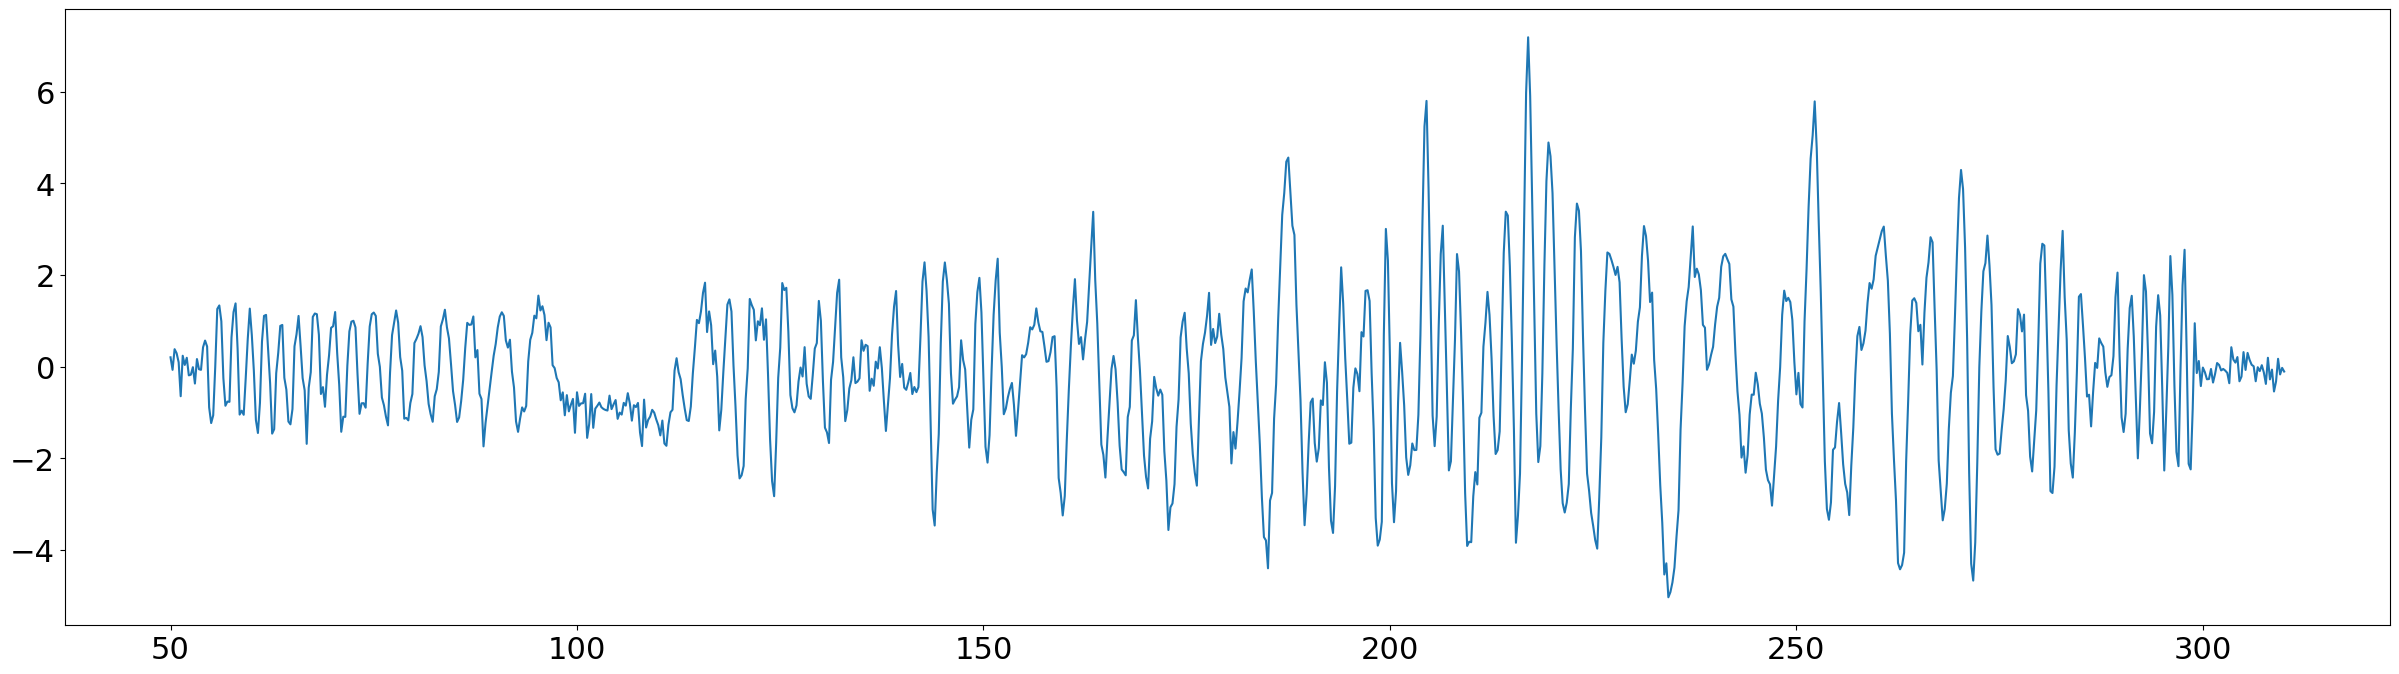

In [24]:
#signal input
plt.plot(signal_vals_trunc[0, :], signal_vals_trunc[1, :])

In [25]:
""""
requires: cosAmps, sinAmps, wavenums, nharmonics, vertShift (=0), cache_y2s (for sarr values), cache_y2psi (for psi values)
"""


def calc_sarr_linear(x, yORz, xi):
    """Calculate linear combination of positions for psi computation."""
    return xi * x + (1 - xi) * yORz

# these two arrays are the output of psi at the domain points, required for image integral calculation
def cache_psi(domain, F, dx, xi, cosAmps, sinAmps, wavenums):
    cache_y2s = {}
    cache_y2psi = {}
    """Cache psi values for a given domain and parameters."""
    for i, y in enumerate(domain):
        xarr = domain[np.maximum(0, i - int(F/2/dx)): i + int(F/2/dx) + 1]
        sarr = calc_sarr_linear(xarr, y, xi)
        cache_y2s[y] = sarr
        cache_y2psi[y] = np.real(np.sum(cosAmps * np.cos(np.outer(sarr, wavenums)) + sinAmps * np.sin(np.outer(sarr, wavenums)), axis=1))
    return cache_y2psi

In [26]:
y2psi = cache_psi(x_range_trunc, F, DX, xi, cos_coeffs, sin_coeffs, kpsi_values)

In [27]:
y2psi
psi_disc = []
for yidx, y in enumerate(x_range_trunc):
    psi_disc.append(y2psi[y])


psi_disc

[array([ 7.46236277e+00,  7.34698113e+00,  7.23319641e+00,  7.12116517e+00,
         7.01103451e+00,  6.90294161e+00,  6.79701325e+00,  6.69336536e+00,
         6.59210269e+00,  6.49331846e+00,  6.39709413e+00,  6.30349915e+00,
         6.21259084e+00,  6.12441424e+00,  6.03900214e+00,  5.95637502e+00,
         5.87654113e+00,  5.79949664e+00,  5.72522578e+00,  5.65370109e+00,
         5.58488370e+00,  5.51872360e+00,  5.45516013e+00,  5.39412228e+00,
         5.33552924e+00,  5.27929089e+00,  5.22530832e+00,  5.17347445e+00,
         5.12367463e+00,  5.07578731e+00,  5.02968467e+00,  4.98523336e+00,
         4.94229522e+00,  4.90072798e+00,  4.86038607e+00,  4.82112130e+00,
         4.78278370e+00,  4.74522224e+00,  4.70828562e+00,  4.67182300e+00,
         4.63568478e+00,  4.59972333e+00,  4.56379369e+00,  4.52775430e+00,
         4.49146766e+00,  4.45480098e+00,  4.41762681e+00,  4.37982361e+00,
         4.34127633e+00,  4.30187690e+00,  4.26152470e+00,  4.22012702e+00,
         4.1

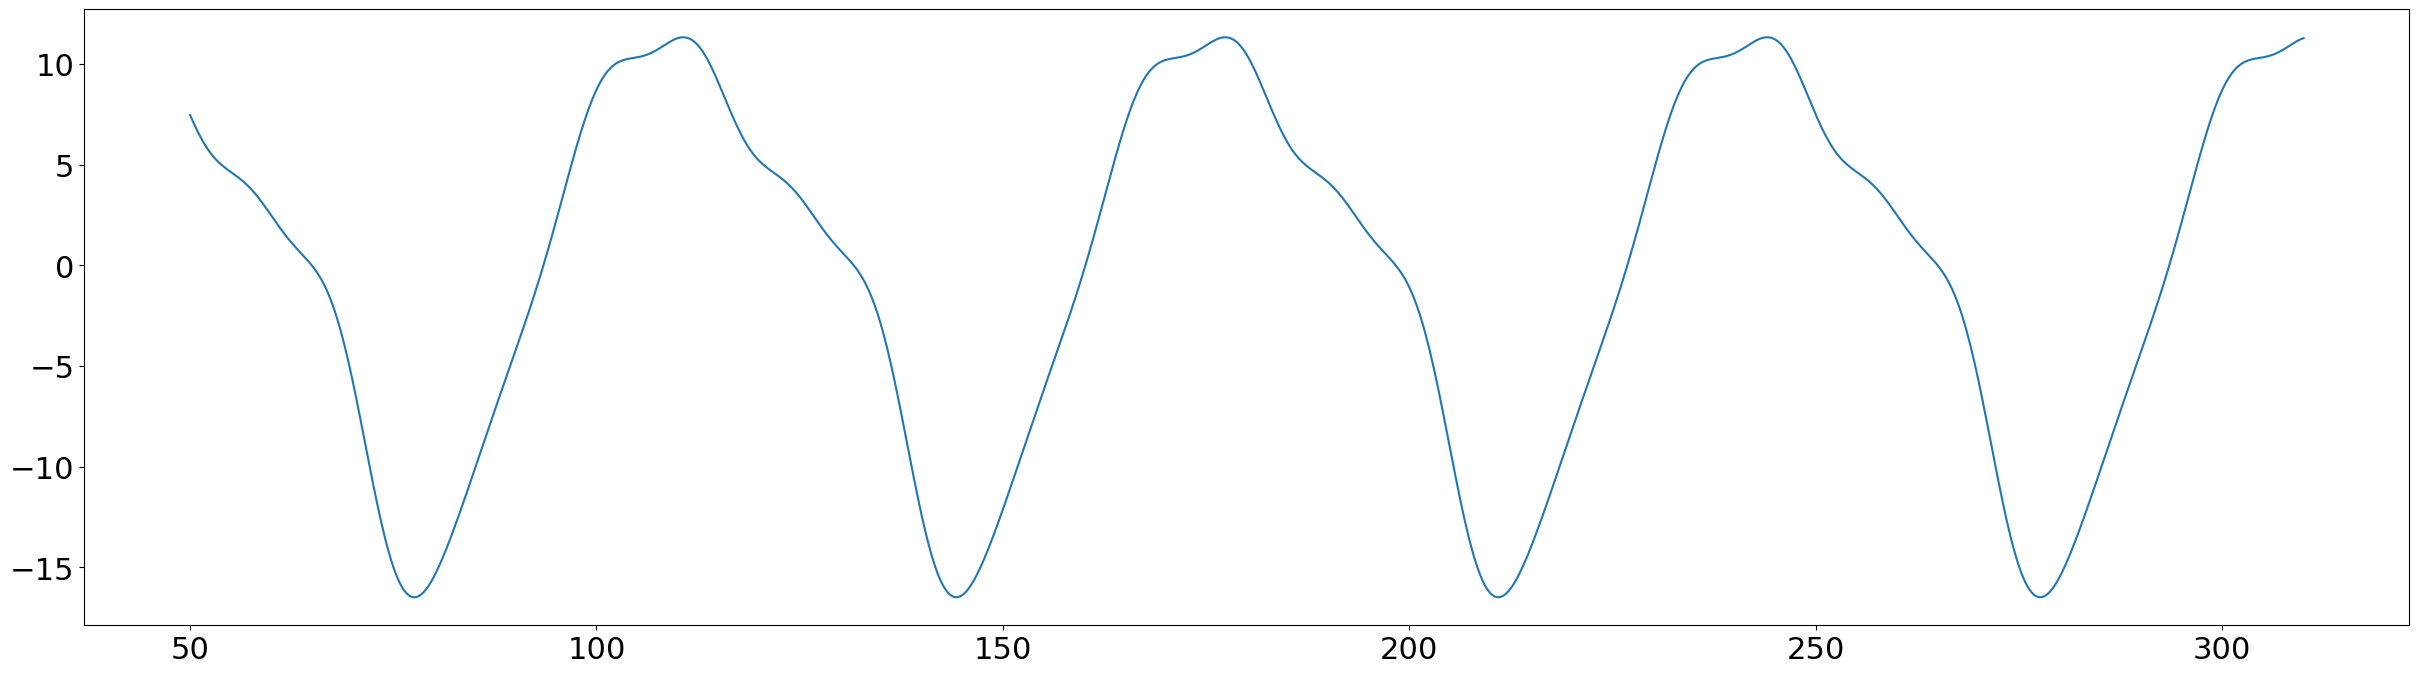

In [28]:
def build_psi_values(kpsi, compl_ampls, x):
    val = np.zeros_like(x, dtype=float)
    for ik in range(len(compl_ampls)):
        val += np.real(compl_ampls[ik] * np.exp(1j * kpsi[ik] * x))
    return val

psi_vals = build_psi_values(kpsi_values, psi_coeffs_vals, x_range_trunc)
plt.plot(x_range_trunc, psi_vals)

In [29]:
# assuming same discretization
psi_vals.shape

(1041,)

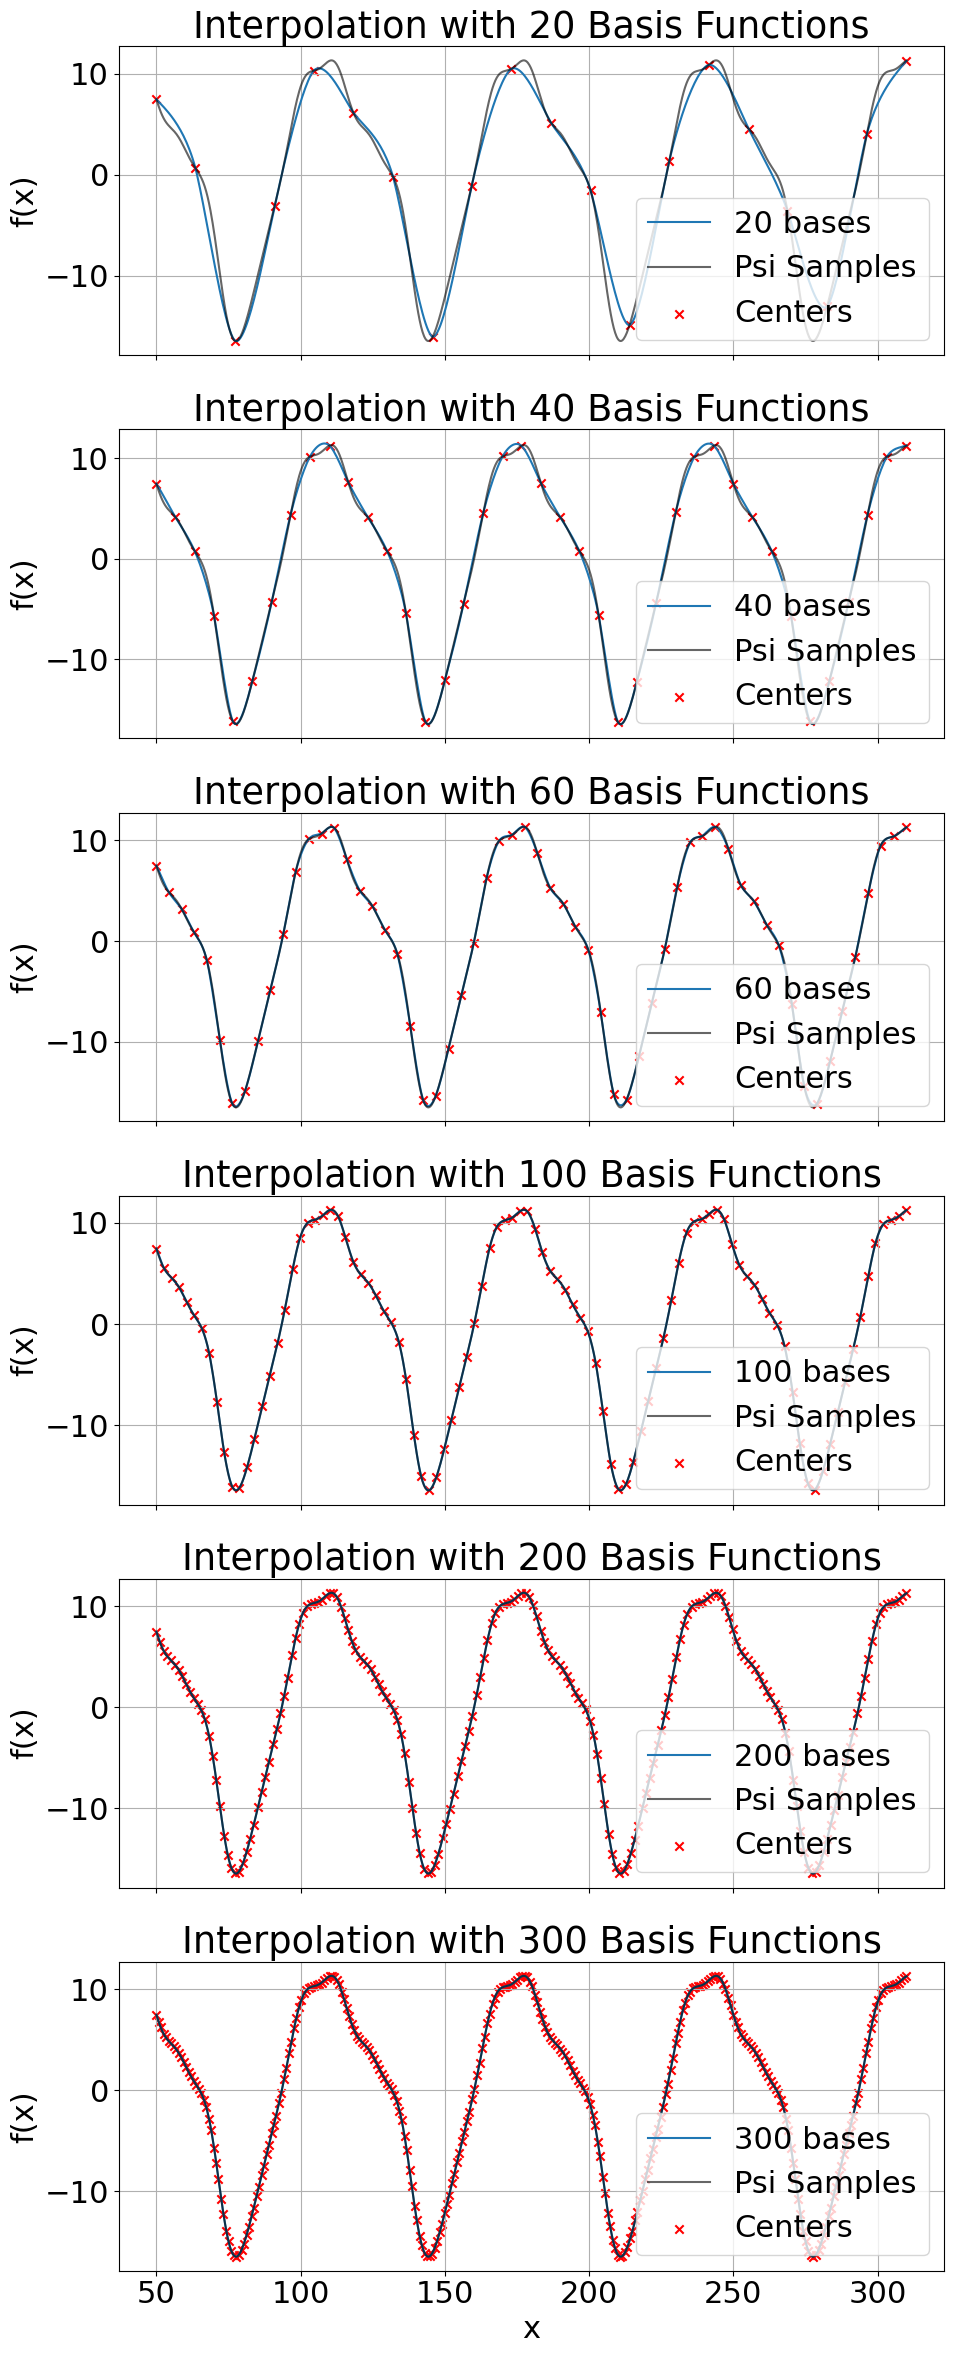

In [30]:
from scipy.interpolate import RBFInterpolator
data_stack = np.vstack((x_range_trunc, psi_vals)).T
rbf_interp = RBFInterpolator(data_stack[:, 0:1], data_stack[:, 1], kernel='linear', epsilon=1.0)

x_dense = np.linspace(x_range_trunc.min(), x_range_trunc.max(), 500).reshape(-1, 1)


num_bases_list = [20, 40, 60, 100, 200, 300]

# Generate dense query points for prediction
x_dense = np.linspace(x_range_trunc.min(), x_range_trunc.max(), 500).reshape(-1, 1)

# Create vertically stacked subplots for each number of basis functions
fig, axes = plt.subplots(len(num_bases_list), 1, figsize=(10, 4 * len(num_bases_list)), sharex=True)

for ax, num_bases in zip(axes, num_bases_list):
    center_indices = np.linspace(0, len(x_range_trunc) - 1, num_bases, dtype=int)
    centers = x_range_trunc[center_indices].reshape(-1, 1)
    values_at_centers = psi_vals[center_indices]

    rbf_interp = RBFInterpolator(
        centers,
        values_at_centers,
        kernel='thin_plate_spline',
        epsilon=1.0
    )

    interp_vals = rbf_interp(x_dense)
    ax.plot(x_dense.ravel(), interp_vals, label=f'{num_bases} bases')
    ax.plot(x_range_trunc, psi_vals, color='black', alpha=0.6, label='Psi Samples')
    ax.scatter(centers.ravel(), values_at_centers, color='red', marker='x', label='Centers')
    ax.set_ylabel('f(x)')
    ax.set_title(f'Interpolation with {num_bases} Basis Functions')
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel('x')
plt.tight_layout()
plt.show()


In [31]:
# just defining window funcs
def rect_window(arr):
    """
    Apply a rectangular window function to an array.
    
    Args:
        arr (numpy.ndarray): The input array to which the window will be applied.
        
    Returns:
        numpy.ndarray: An array of ones with the same shape as the input array.
    """
    return np.ones_like(arr)

def parab_window(arr):
    """
    Apply a parabolic window function to an array.
    
    Args:
        arr (numpy.ndarray): The input array to which the window will be applied.
        
    Returns:
        numpy.ndarray: An array where each element is calculated using a parabolic function centered within the array bounds.
    """
    arr_min, arr_max = np.min(arr), np.max(arr)
    return 1 - ((2 * (arr - arr_min)) / (arr_max - arr_min) - 1) ** 2

def parab_scaled_window(arr):
    """
    Apply a scaled parabolic window function to an array where the window's area sums to 1.
    
    Args:
        arr (numpy.ndarray): The input array to which the window will be applied.
        
    Returns:
        numpy.ndarray: An array where each element is calculated using a parabolic function scaled such that the mean value is 1.
    """
    arr_min, arr_max = np.min(arr), np.max(arr)
    window_arr = 1 - ((2 * (arr - arr_min)) / (arr_max - arr_min) - 1) ** 2
    return window_arr / np.mean(window_arr)



def calc_psi_cache(base, y, cos_coeffs, sin_coeffs, wavenums, xi):
    """Cache psi values for a given y."""
    sarr =  xi * base + (1 - xi) * y  # Calculate sarr directly using the base array
    psi_vals = np.real(np.sum(
        cos_coeffs * np.cos(np.outer(sarr, wavenums)) +
        sin_coeffs * np.sin(np.outer(sarr, wavenums)),
        axis=1
    ))
    return psi_vals

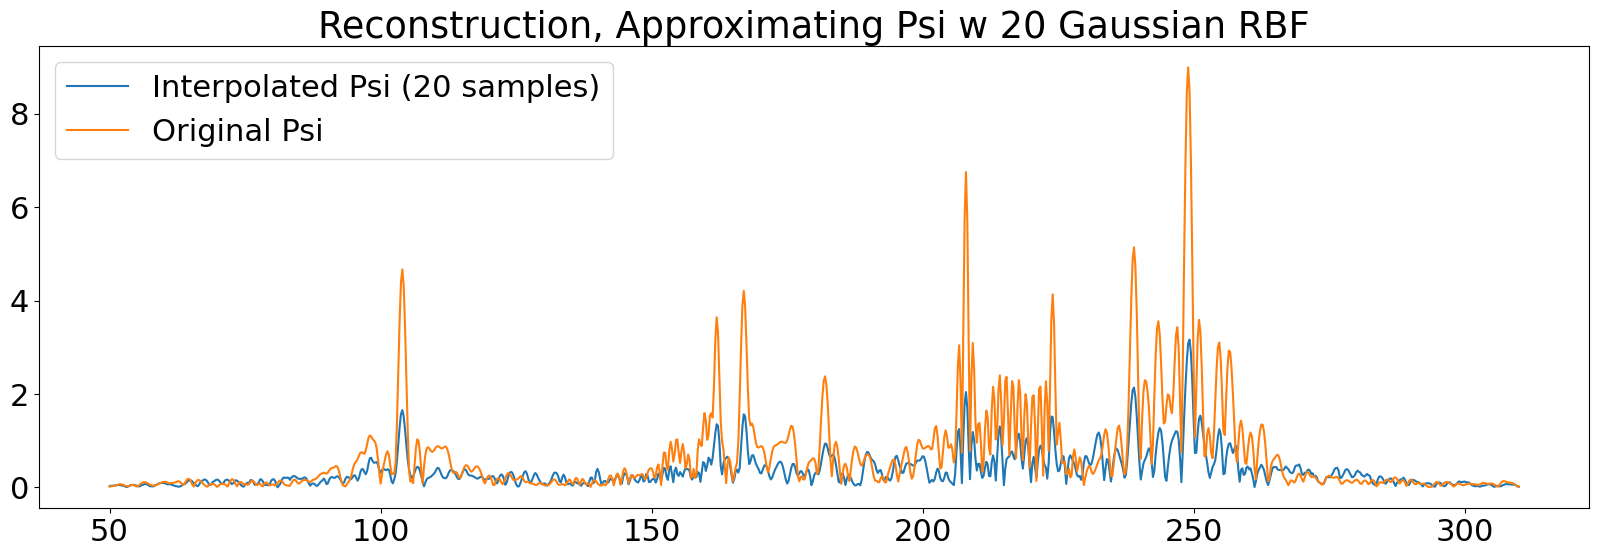

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator

# Configuration
x_dense = np.linspace(x_range_trunc.min(), x_range_trunc.max(), 500).reshape(-1, 1)
center_indices = np.linspace(0, len(x_range_trunc) - 1, num_bases, dtype=int)
centers = x_range_trunc[center_indices].reshape(-1, 1)

real_signal = np.real(signal_vals_trunc[0, :])
image_integral = np.empty_like(signal_vals_trunc[1, :], dtype='complex128')
image_integral_approx = np.empty_like(signal_vals_trunc[1, :], dtype='complex128')

num_rbf_centers = 20  # Use only 20 samples for interpolation

for yidx, y in enumerate(x_range_trunc):
    x0 = max(real_signal[0], y - F / 2)
    x1 = min(real_signal[-1], y + F / 2)
    mask = (real_signal >= x0) & (real_signal <= x1)

    base = real_signal[mask]
    signal_vals = signal_vals_trunc[1, mask]
    waveform = np.exp(-1j * np.pi * (base - y) ** 2 / F)

    # Compute psi_vals from the original function
    psi_vals = np.exp(1j * calc_psi_cache(base, y, cos_coeffs, sin_coeffs, kpsi_values, xi))
    window = rect_window(base)

    # Select 20 evenly spaced indices from base for interpolation
    if len(base) >= num_rbf_centers:
        interp_indices = np.linspace(0, len(base) - 1, num_rbf_centers, dtype=int)
    else:
        interp_indices = np.arange(len(base))  # Fallback if too few points

    base_subset = base[interp_indices].reshape(-1, 1)
    psi_vals_real_subset = np.real(psi_vals[interp_indices])
    psi_vals_imag_subset = np.imag(psi_vals[interp_indices])

    # Create RBF interpolators using only the subset
    rbf_real = RBFInterpolator(base_subset, psi_vals_real_subset, kernel = 'gaussian', epsilon=1.0)
    rbf_imag = RBFInterpolator(base_subset, psi_vals_imag_subset, kernel = 'gaussian', epsilon=1.0)

    # Interpolate at full base locations
    base_reshaped = base.reshape(-1, 1)
    psi_interp_real = rbf_real(base_reshaped).flatten()
    psi_interp_imag = rbf_imag(base_reshaped).flatten()

    # Combine interpolated parts into complex psi
    psi_interp = psi_interp_real + 1j * psi_interp_imag

    heights_approx = waveform * signal_vals * window * psi_interp
    image_integral_approx[yidx] = np.trapz(heights_approx, base, DX) / F

    heights = waveform * signal_vals * window * psi_vals
    image_integral[yidx] = np.trapz(heights, base, DX) / F

# Plot comparison
plt.figure(figsize=(20, 6))
plt.plot(x_range_trunc, np.abs(image_integral_approx) / DX, label='Interpolated Psi (20 samples)')
plt.plot(x_range_trunc, np.abs(image_integral) / DX, label='Original Psi')
plt.title("Reconstruction, Approximating Psi w 20 Gaussian RBF")
plt.legend()
plt.show()


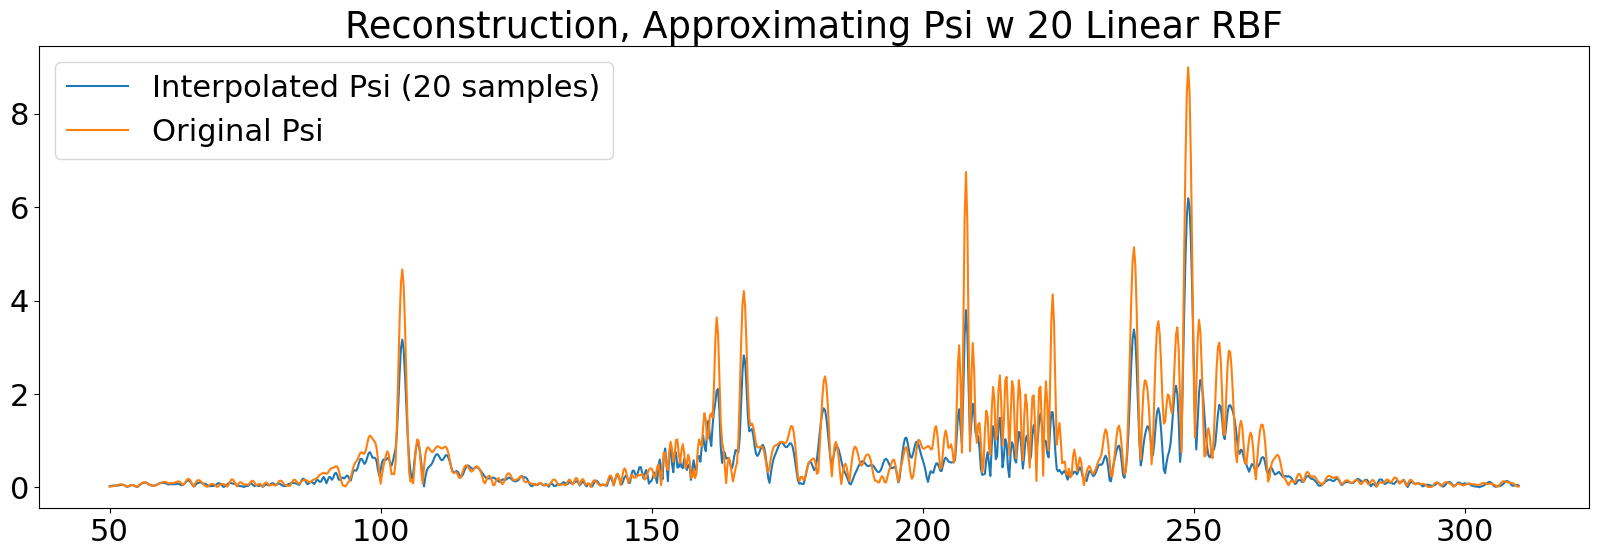

In [33]:
# Configuration
x_dense = np.linspace(x_range_trunc.min(), x_range_trunc.max(), 500).reshape(-1, 1)
center_indices = np.linspace(0, len(x_range_trunc) - 1, num_bases, dtype=int)
centers = x_range_trunc[center_indices].reshape(-1, 1)

real_signal = np.real(signal_vals_trunc[0, :])
image_integral = np.empty_like(signal_vals_trunc[1, :], dtype='complex128')
image_integral_approx = np.empty_like(signal_vals_trunc[1, :], dtype='complex128')

num_rbf_centers = 20  # Use only 20 samples for interpolation

for yidx, y in enumerate(x_range_trunc):
    x0 = max(real_signal[0], y - F / 2)
    x1 = min(real_signal[-1], y + F / 2)
    mask = (real_signal >= x0) & (real_signal <= x1)

    base = real_signal[mask]
    signal_vals = signal_vals_trunc[1, mask]
    waveform = np.exp(-1j * np.pi * (base - y) ** 2 / F)

    # Compute psi_vals from the original function
    psi_vals = np.exp(1j * calc_psi_cache(base, y, cos_coeffs, sin_coeffs, kpsi_values, xi))
    window = rect_window(base)

    # Select 20 evenly spaced indices from base for interpolation
    if len(base) >= num_rbf_centers:
        interp_indices = np.linspace(0, len(base) - 1, num_rbf_centers, dtype=int)
    else:
        interp_indices = np.arange(len(base))  # Fallback if too few points

    base_subset = base[interp_indices].reshape(-1, 1)
    psi_vals_real_subset = np.real(psi_vals[interp_indices])
    psi_vals_imag_subset = np.imag(psi_vals[interp_indices])

    # Create RBF interpolators using only the subset
    rbf_real = RBFInterpolator(base_subset, psi_vals_real_subset, kernel = 'linear', epsilon=1.0)
    rbf_imag = RBFInterpolator(base_subset, psi_vals_imag_subset, kernel = 'linear', epsilon=1.0)

    # Interpolate at full base locations
    base_reshaped = base.reshape(-1, 1)
    psi_interp_real = rbf_real(base_reshaped).flatten()
    psi_interp_imag = rbf_imag(base_reshaped).flatten()

    # Combine interpolated parts into complex psi
    psi_interp = psi_interp_real + 1j * psi_interp_imag

    heights_approx = waveform * signal_vals * window * psi_interp
    image_integral_approx[yidx] = np.trapz(heights_approx, base, DX) / F

    heights = waveform * signal_vals * window * psi_vals
    image_integral[yidx] = np.trapz(heights, base, DX) / F

# Plot comparison
plt.figure(figsize=(20, 6))
plt.plot(x_range_trunc, np.abs(image_integral_approx) / DX, label='Interpolated Psi (20 samples)')
plt.plot(x_range_trunc, np.abs(image_integral) / DX, label='Original Psi')
plt.title("Reconstruction, Approximating Psi w 20 Linear RBF")
plt.legend()
plt.show()

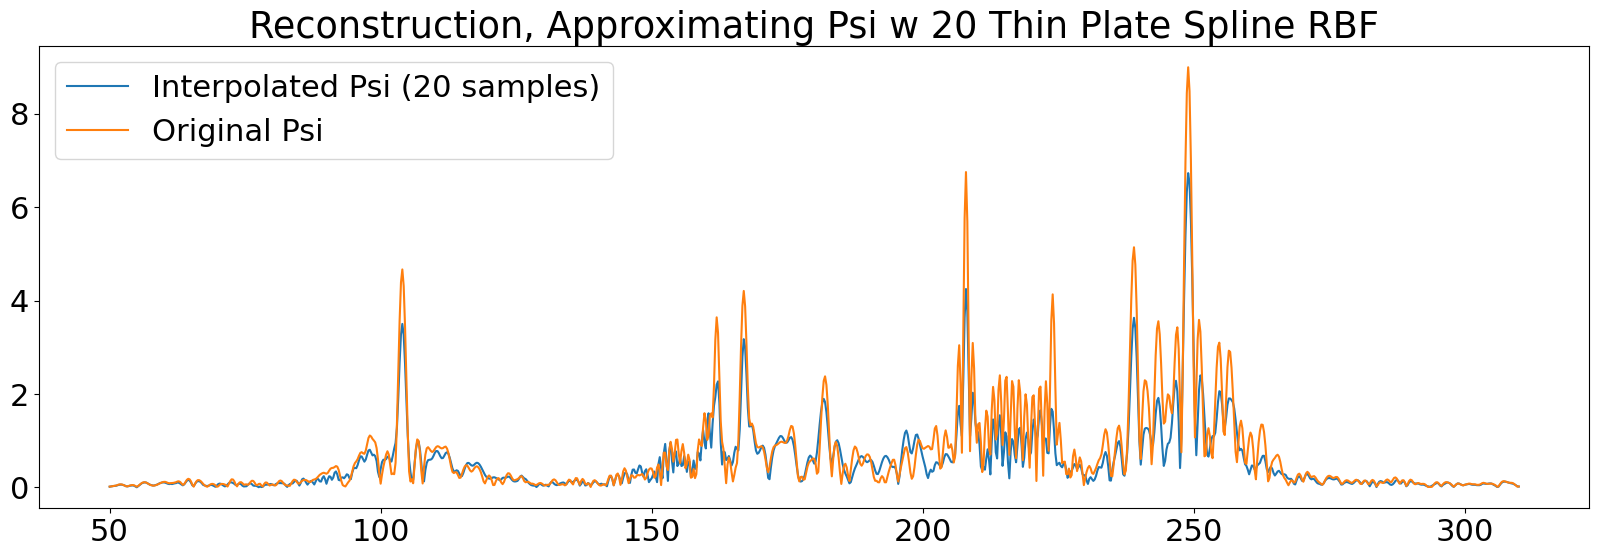

In [34]:
# Configuration
x_dense = np.linspace(x_range_trunc.min(), x_range_trunc.max(), 500).reshape(-1, 1)
center_indices = np.linspace(0, len(x_range_trunc) - 1, num_bases, dtype=int)
centers = x_range_trunc[center_indices].reshape(-1, 1)

real_signal = np.real(signal_vals_trunc[0, :])
image_integral = np.empty_like(signal_vals_trunc[1, :], dtype='complex128')
image_integral_approx = np.empty_like(signal_vals_trunc[1, :], dtype='complex128')

num_rbf_centers = 20  # Use only 20 samples for interpolation

for yidx, y in enumerate(x_range_trunc):
    x0 = max(real_signal[0], y - F / 2)
    x1 = min(real_signal[-1], y + F / 2)
    mask = (real_signal >= x0) & (real_signal <= x1)

    base = real_signal[mask]
    signal_vals = signal_vals_trunc[1, mask]
    waveform = np.exp(-1j * np.pi * (base - y) ** 2 / F)

    # Compute psi_vals from the original function
    psi_vals = np.exp(1j * calc_psi_cache(base, y, cos_coeffs, sin_coeffs, kpsi_values, xi))
    window = rect_window(base)

    # Select 20 evenly spaced indices from base for interpolation
    if len(base) >= num_rbf_centers:
        interp_indices = np.linspace(0, len(base) - 1, num_rbf_centers, dtype=int)
    else:
        interp_indices = np.arange(len(base))  # Fallback if too few points

    base_subset = base[interp_indices].reshape(-1, 1)
    psi_vals_real_subset = np.real(psi_vals[interp_indices])
    psi_vals_imag_subset = np.imag(psi_vals[interp_indices])

    # Create RBF interpolators using only the subset
    rbf_real = RBFInterpolator(base_subset, psi_vals_real_subset, kernel = 'thin_plate_spline', epsilon=1.0)
    rbf_imag = RBFInterpolator(base_subset, psi_vals_imag_subset, kernel = 'thin_plate_spline', epsilon=1.0)

    # Interpolate at full base locations
    base_reshaped = base.reshape(-1, 1)
    psi_interp_real = rbf_real(base_reshaped).flatten()
    psi_interp_imag = rbf_imag(base_reshaped).flatten()

    # Combine interpolated parts into complex psi
    psi_interp = psi_interp_real + 1j * psi_interp_imag

    heights_approx = waveform * signal_vals * window * psi_interp
    image_integral_approx[yidx] = np.trapz(heights_approx, base, DX) / F

    heights = waveform * signal_vals * window * psi_vals
    image_integral[yidx] = np.trapz(heights, base, DX) / F

# Plot comparison
plt.figure(figsize=(20, 6))
plt.plot(x_range_trunc, np.abs(image_integral_approx) / DX, label='Interpolated Psi (20 samples)')
plt.plot(x_range_trunc, np.abs(image_integral) / DX, label='Original Psi')
plt.title("Reconstruction, Approximating Psi w 20 Thin Plate Spline RBF")
plt.legend()
plt.show()

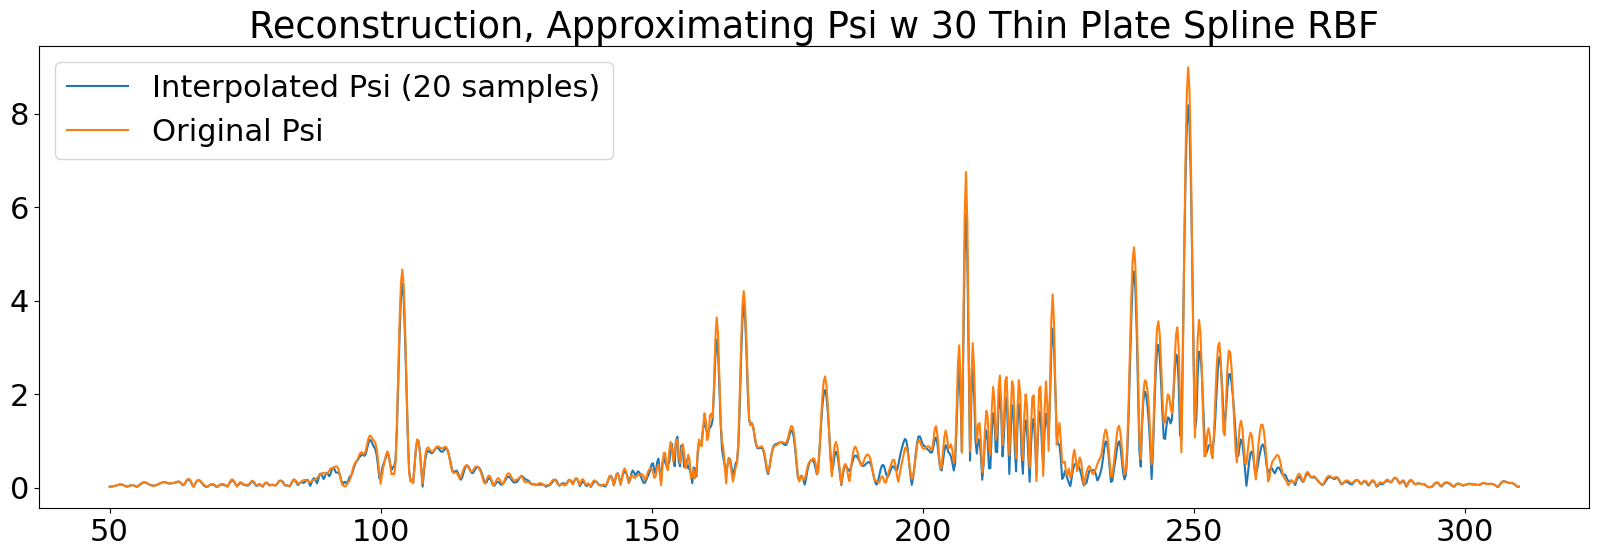

In [35]:
# Configuration
x_dense = np.linspace(x_range_trunc.min(), x_range_trunc.max(), 500).reshape(-1, 1)
center_indices = np.linspace(0, len(x_range_trunc) - 1, num_bases, dtype=int)
centers = x_range_trunc[center_indices].reshape(-1, 1)

real_signal = np.real(signal_vals_trunc[0, :])
image_integral = np.empty_like(signal_vals_trunc[1, :], dtype='complex128')
image_integral_approx = np.empty_like(signal_vals_trunc[1, :], dtype='complex128')

num_rbf_centers = 30  # Use only 20 samples for interpolation

for yidx, y in enumerate(x_range_trunc):
    x0 = max(real_signal[0], y - F / 2)
    x1 = min(real_signal[-1], y + F / 2)
    mask = (real_signal >= x0) & (real_signal <= x1)

    base = real_signal[mask]
    signal_vals = signal_vals_trunc[1, mask]
    waveform = np.exp(-1j * np.pi * (base - y) ** 2 / F)

    # Compute psi_vals from the original function
    psi_vals = np.exp(1j * calc_psi_cache(base, y, cos_coeffs, sin_coeffs, kpsi_values, xi))
    window = rect_window(base)

    # Select 20 evenly spaced indices from base for interpolation
    if len(base) >= num_rbf_centers:
        interp_indices = np.linspace(0, len(base) - 1, num_rbf_centers, dtype=int)
    else:
        interp_indices = np.arange(len(base))  # Fallback if too few points

    base_subset = base[interp_indices].reshape(-1, 1)
    psi_vals_real_subset = np.real(psi_vals[interp_indices])
    psi_vals_imag_subset = np.imag(psi_vals[interp_indices])

    # Create RBF interpolators using only the subset
    rbf_real = RBFInterpolator(base_subset, psi_vals_real_subset, kernel = 'thin_plate_spline', epsilon=1.0)
    rbf_imag = RBFInterpolator(base_subset, psi_vals_imag_subset, kernel = 'thin_plate_spline', epsilon=1.0)

    # Interpolate at full base locations
    base_reshaped = base.reshape(-1, 1)
    psi_interp_real = rbf_real(base_reshaped).flatten()
    psi_interp_imag = rbf_imag(base_reshaped).flatten()

    # Combine interpolated parts into complex psi
    psi_interp = psi_interp_real + 1j * psi_interp_imag

    heights_approx = waveform * signal_vals * window * psi_interp
    image_integral_approx[yidx] = np.trapz(heights_approx, base, DX) / F

    heights = waveform * signal_vals * window * psi_vals
    image_integral[yidx] = np.trapz(heights, base, DX) / F

# Plot comparison
plt.figure(figsize=(20, 6))
plt.plot(x_range_trunc, np.abs(image_integral_approx) / DX, label='Interpolated Psi (20 samples)')
plt.plot(x_range_trunc, np.abs(image_integral) / DX, label='Original Psi')
plt.title("Reconstruction, Approximating Psi w 30 Thin Plate Spline RBF")
plt.legend()
plt.show()

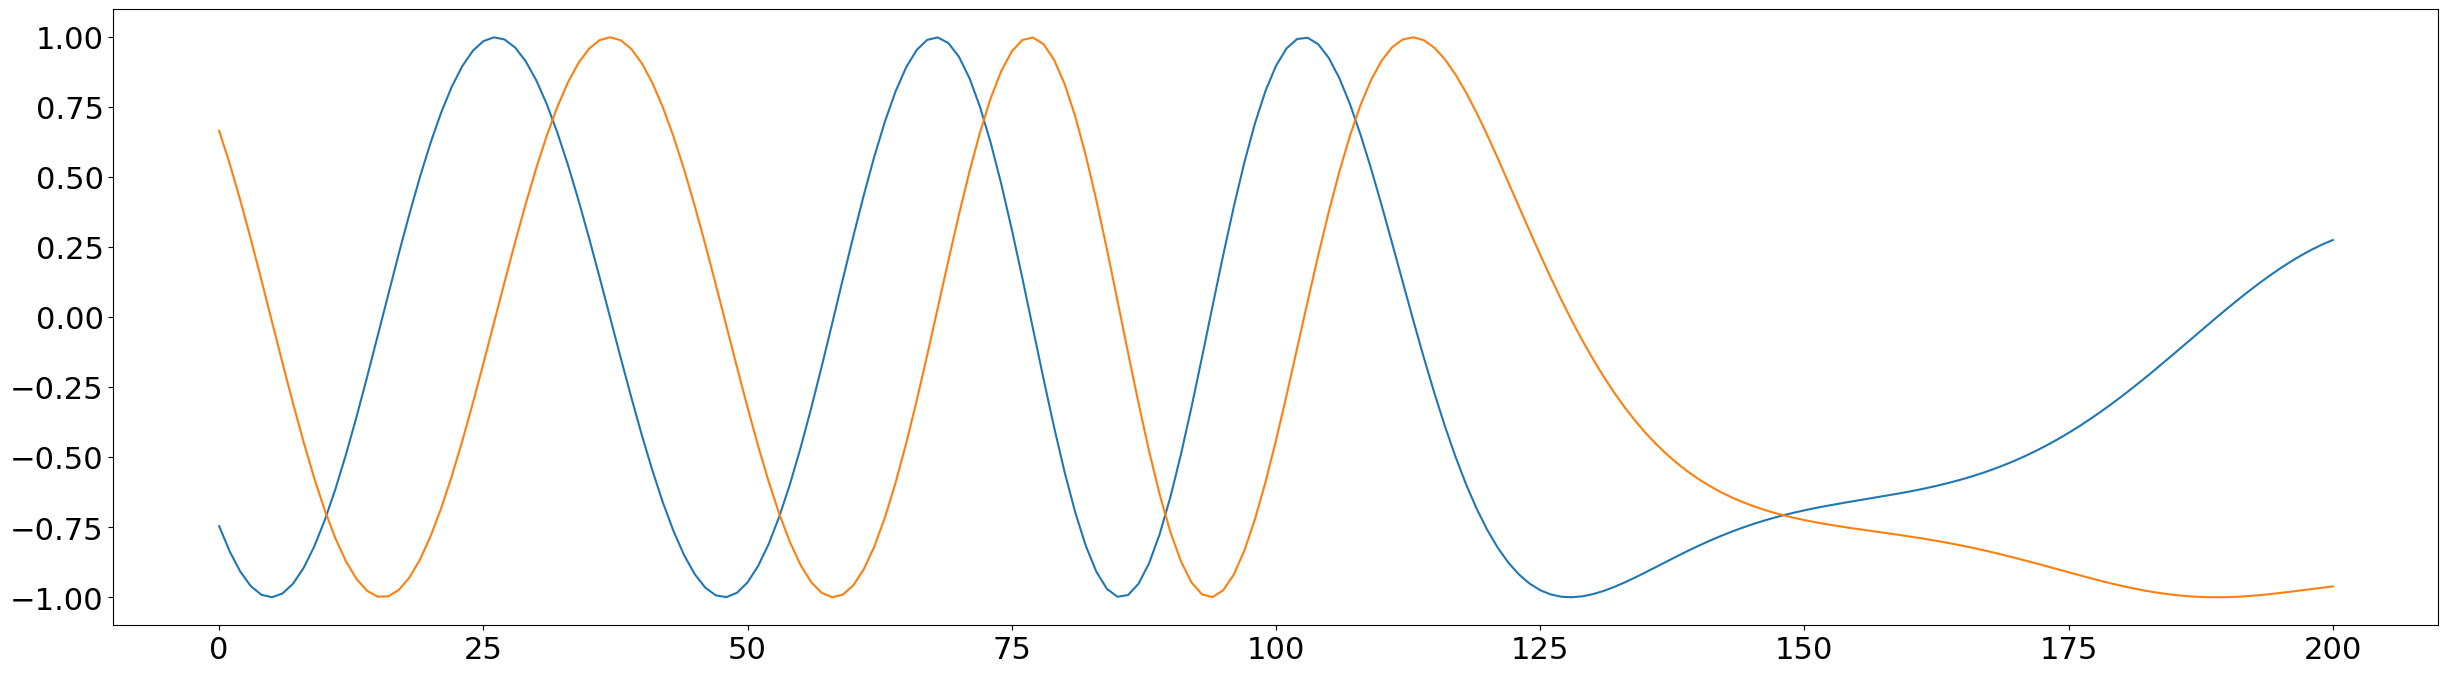

In [36]:
psi_vals_real = [k.real for k in psi_vals]
psi_vals_imag = [k.imag for k in psi_vals]
plt.plot(psi_vals_real)
plt.plot(psi_vals_imag)

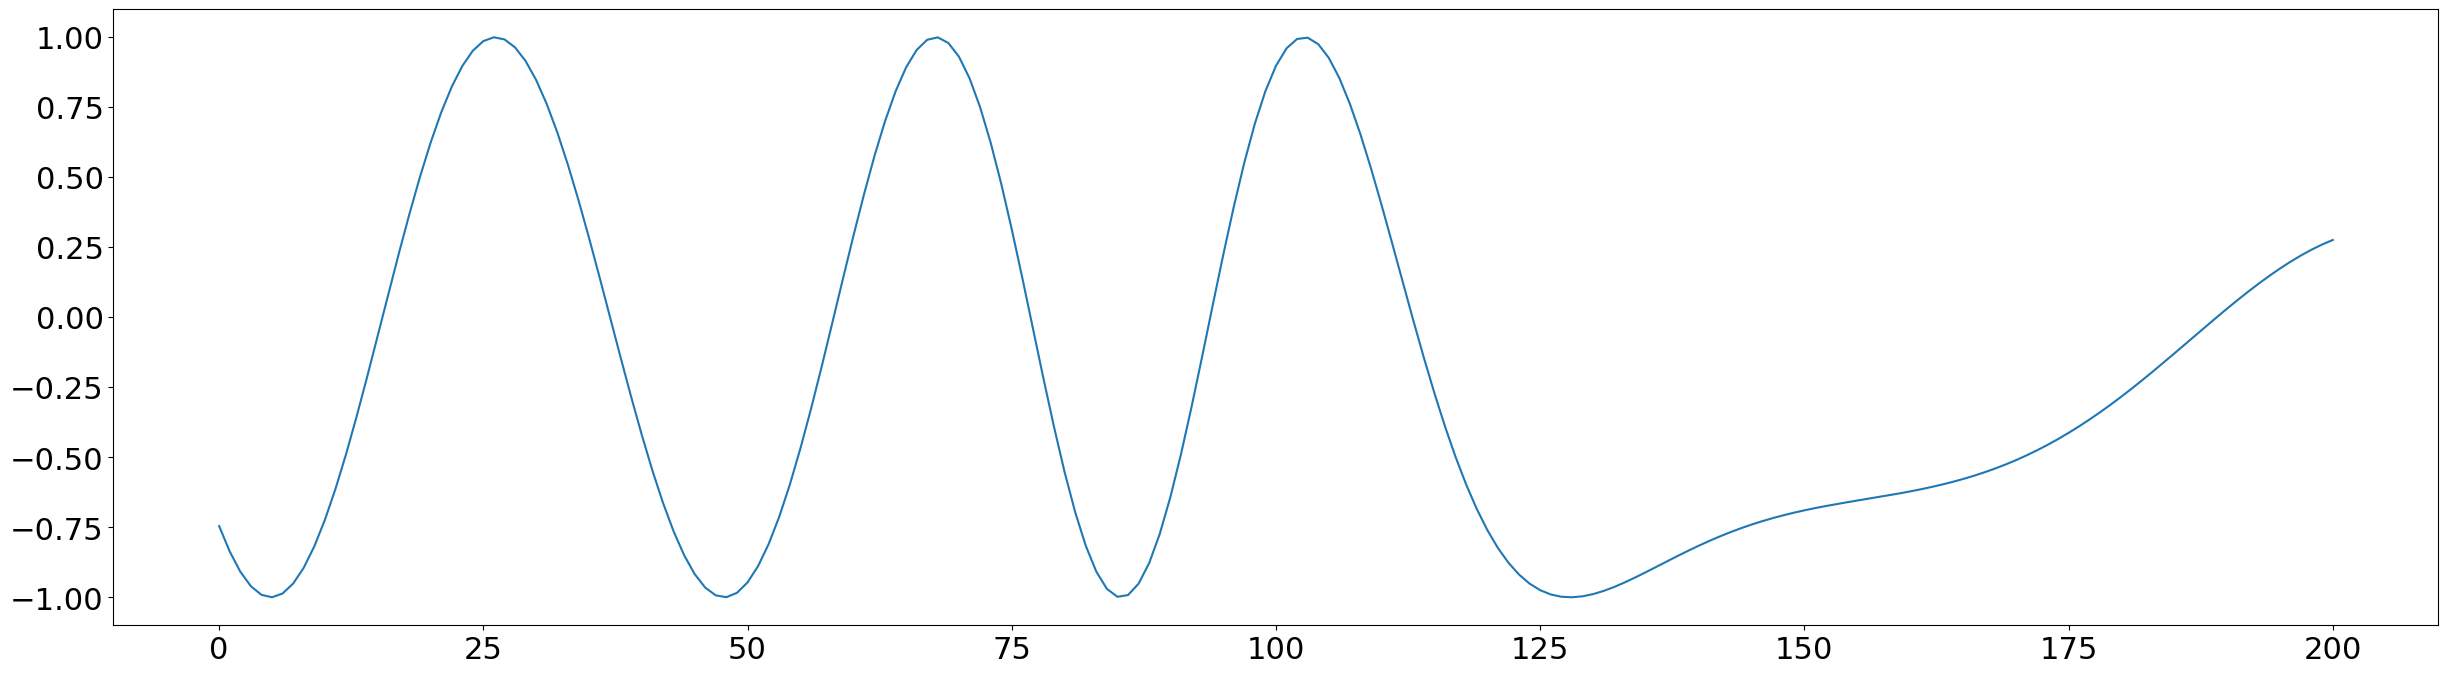

In [37]:
num_centers = 10

indices=np.linspace(0, len(psi_vals_real) - 1, num_centers, dtype = int)

psi_centers_real = [psi_vals_real[i] for i in indices]
psi_centers_imag = [psi_vals_imag[i] for i in indices]
centers = x_range_trunc[indices].reshape(-1, 1)

real_interp = RBFInterpolator(
        centers,
        psi_centers_real,
        kernel='thin_plate_spline',
        epsilon=1.0
    )

imag_interp = RBFInterpolator(
    centers,
    psi_centers_imag, 
    kernel = "thin_plate_spline",
    epsilon=1.0
)

plt.plot(psi_vals_real)

In [38]:
centers

array([[ 50.  ],
       [ 55.5 ],
       [ 61.  ],
       [ 66.5 ],
       [ 72.  ],
       [ 77.75],
       [ 83.25],
       [ 88.75],
       [ 94.25],
       [100.  ]])